In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

print("ENTRENAMIENTO DEL MODELO DE PREDICCIÓN")
print("Dataset: Dewatering Solutions Realista")
print("=" * 50)

ENTRENAMIENTO DEL MODELO DE PREDICCIÓN
Dataset: Dewatering Solutions Realista


In [2]:
df = pd.read_csv('../data/dewatering_realistic_supplier_dataset.csv')

print(f"Dataset cargado: {df.shape[0]} transacciones")
print(f"Período: {df['date'].min()} a {df['date'].max()}")

# Crear carpeta models si no existe
os.makedirs('../models', exist_ok=True)

Dataset cargado: 1211 transacciones
Período: 2022-01-01 a 2024-12-31


In [3]:
print("\nPREPARANDO FEATURES PARA EL MODELO")

# Features seleccionadas adaptadas al nuevo dataset
features_for_model = [
    'quality_rating',
    'price_usd', 
    'delivery_days',
    'payment_terms_days',
    'shipping_included',
    'express_available',
    'order_urgency',
    'quantity_needed',
    'budget_available',
    'product_type',
    'country',
    'incoterms',
    'month',
    'quarter'
]

# Verificar que todas las features existen
missing_features = [f for f in features_for_model if f not in df.columns]
if missing_features:
    print(f"Features faltantes: {missing_features}")
    features_for_model = [f for f in features_for_model if f in df.columns]

print(f"Features seleccionadas: {len(features_for_model)}")
for feature in features_for_model:
    print(f"   • {feature}")


PREPARANDO FEATURES PARA EL MODELO
Features seleccionadas: 14
   • quality_rating
   • price_usd
   • delivery_days
   • payment_terms_days
   • shipping_included
   • express_available
   • order_urgency
   • quantity_needed
   • budget_available
   • product_type
   • country
   • incoterms
   • month
   • quarter


In [4]:
print(f"\nENCODING DE VARIABLES CATEGÓRICAS")

X = df[features_for_model].copy()
y = df['supplier_name'].copy()  # Predecimos el proveedor óptimo

# Encoders para variables categóricas
label_encoders = {}
categorical_features = ['order_urgency', 'product_type', 'country', 'incoterms', 'quarter']

for feature in categorical_features:
    if feature in X.columns:
        le = LabelEncoder()
        X[feature] = le.fit_transform(X[feature].astype(str))
        label_encoders[feature] = le
        print(f"   {feature}: {len(le.classes_)} categorías")

# Convertir booleanos a enteros
boolean_features = ['shipping_included', 'express_available']
for feature in boolean_features:
    if feature in X.columns:
        X[feature] = X[feature].astype(int)

# Encoder para variable objetivo (nombres de proveedores)
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print(f"\nVARIABLE OBJETIVO:")
print(f"   Proveedores únicos: {len(target_encoder.classes_)}")
for i, supplier in enumerate(target_encoder.classes_):
    count = sum(y == supplier)
    print(f"   {i}. {supplier}: {count} transacciones")


ENCODING DE VARIABLES CATEGÓRICAS
   order_urgency: 4 categorías
   product_type: 13 categorías
   country: 4 categorías
   incoterms: 4 categorías
   quarter: 4 categorías

VARIABLE OBJETIVO:
   Proveedores únicos: 6
   0. AIR SLAID TECIDOS TÉCNICOS LTDA: 266 transacciones
   1. Autonics Perú: 123 transacciones
   2. GWI GROUP LIMITED: 191 transacciones
   3. Ritherm: 177 transacciones
   4. TESTORI LATAM SpA: 283 transacciones
   5. Xiamen Borida Products Co., Ltd: 171 transacciones


In [5]:
print(f"\nDIVISIÓN DEL DATASET")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"   Training: {len(X_train)} samples")
print(f"   Testing: {len(X_test)} samples")

# Grid Search para encontrar mejores hiperparámetros
print(f"\nOPTIMIZACIÓN DE HIPERPARÁMETROS")
print("   Ejecutando GridSearchCV...")

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 2, 5],
    'random_state': [42]
}

# Crear modelo base
dt = DecisionTreeClassifier(random_state=42)

# Grid Search con validación cruzada
grid_search = GridSearchCV(
    dt, param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"   Mejores parámetros: {grid_search.best_params_}")
print(f"   Mejor score CV: {grid_search.best_score_:.3f}")


DIVISIÓN DEL DATASET
   Training: 968 samples
   Testing: 243 samples

OPTIMIZACIÓN DE HIPERPARÁMETROS
   Ejecutando GridSearchCV...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
   Mejores parámetros: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'random_state': 42}
   Mejor score CV: 1.000


In [6]:
print(f"\nENTRENAMIENTO DEL MODELO FINAL")

# Usar mejores parámetros
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predicciones
y_pred = best_model.predict(X_test)

# Métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
print(f"   Accuracy en test: {accuracy:.3f}")

# Reporte de clasificación
print(f"\nREPORTE DE CLASIFICACIÓN:")
target_names = target_encoder.classes_
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))



ENTRENAMIENTO DEL MODELO FINAL
   Accuracy en test: 1.000

REPORTE DE CLASIFICACIÓN:
                                 precision    recall  f1-score   support

AIR SLAID TECIDOS TÉCNICOS LTDA       1.00      1.00      1.00        53
                  Autonics Perú       1.00      1.00      1.00        25
              GWI GROUP LIMITED       1.00      1.00      1.00        38
                        Ritherm       1.00      1.00      1.00        36
              TESTORI LATAM SpA       1.00      1.00      1.00        57
Xiamen Borida Products Co., Ltd       1.00      1.00      1.00        34

                       accuracy                           1.00       243
                      macro avg       1.00      1.00      1.00       243
                   weighted avg       1.00      1.00      1.00       243




IMPORTANCIA DE FEATURES
               feature  importance
0       quality_rating    0.408296
10             country    0.240130
11           incoterms    0.183633
3   payment_terms_days    0.167941
1            price_usd    0.000000
2        delivery_days    0.000000
4    shipping_included    0.000000
5    express_available    0.000000
6        order_urgency    0.000000
7      quantity_needed    0.000000
8     budget_available    0.000000
9         product_type    0.000000
12               month    0.000000
13             quarter    0.000000


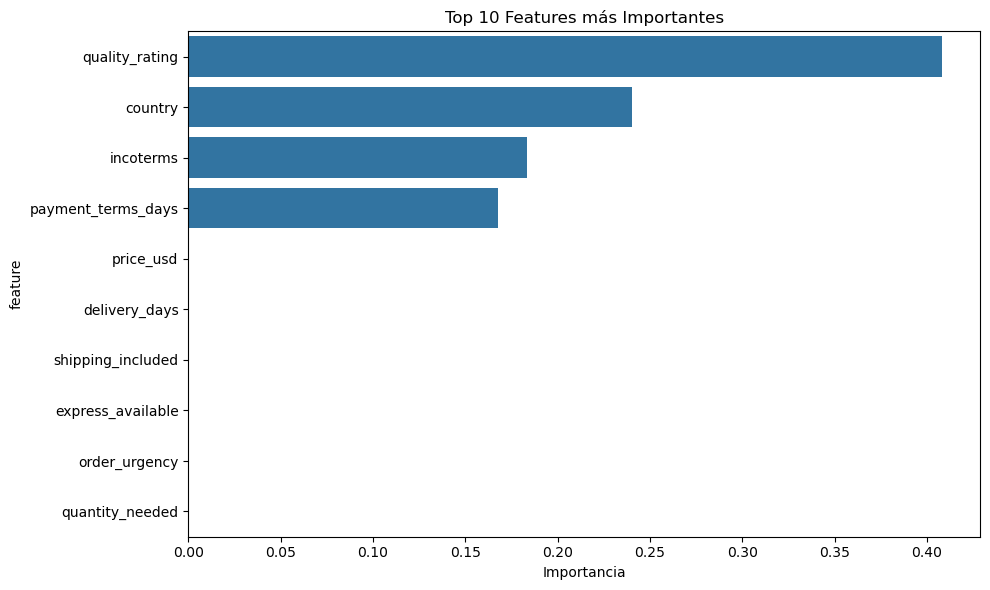


GUARDANDO MODELOS Y ENCODERS
   Modelo guardado: ../models/decision_tree_model.pkl
   Encoders guardados
   Feature names guardados


In [7]:
print(f"\nIMPORTANCIA DE FEATURES")

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance)

# Visualizar importancia de features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Features más Importantes')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

# CELDA 8: Guardar modelos y encoders
print(f"\nGUARDANDO MODELOS Y ENCODERS")

# Guardar modelo entrenado
joblib.dump(best_model, '../models/decision_tree_model.pkl')
print("   Modelo guardado: ../models/decision_tree_model.pkl")

# Guardar encoders
joblib.dump(label_encoders, '../models/label_encoders.pkl')
joblib.dump(target_encoder, '../models/target_encoder.pkl')
print("   Encoders guardados")

# Guardar nombres de features
feature_names = list(X.columns)
joblib.dump(feature_names, '../models/feature_names.pkl')
print("   Feature names guardados")


VISUALIZACIÓN DEL ÁRBOL DE DECISIÓN


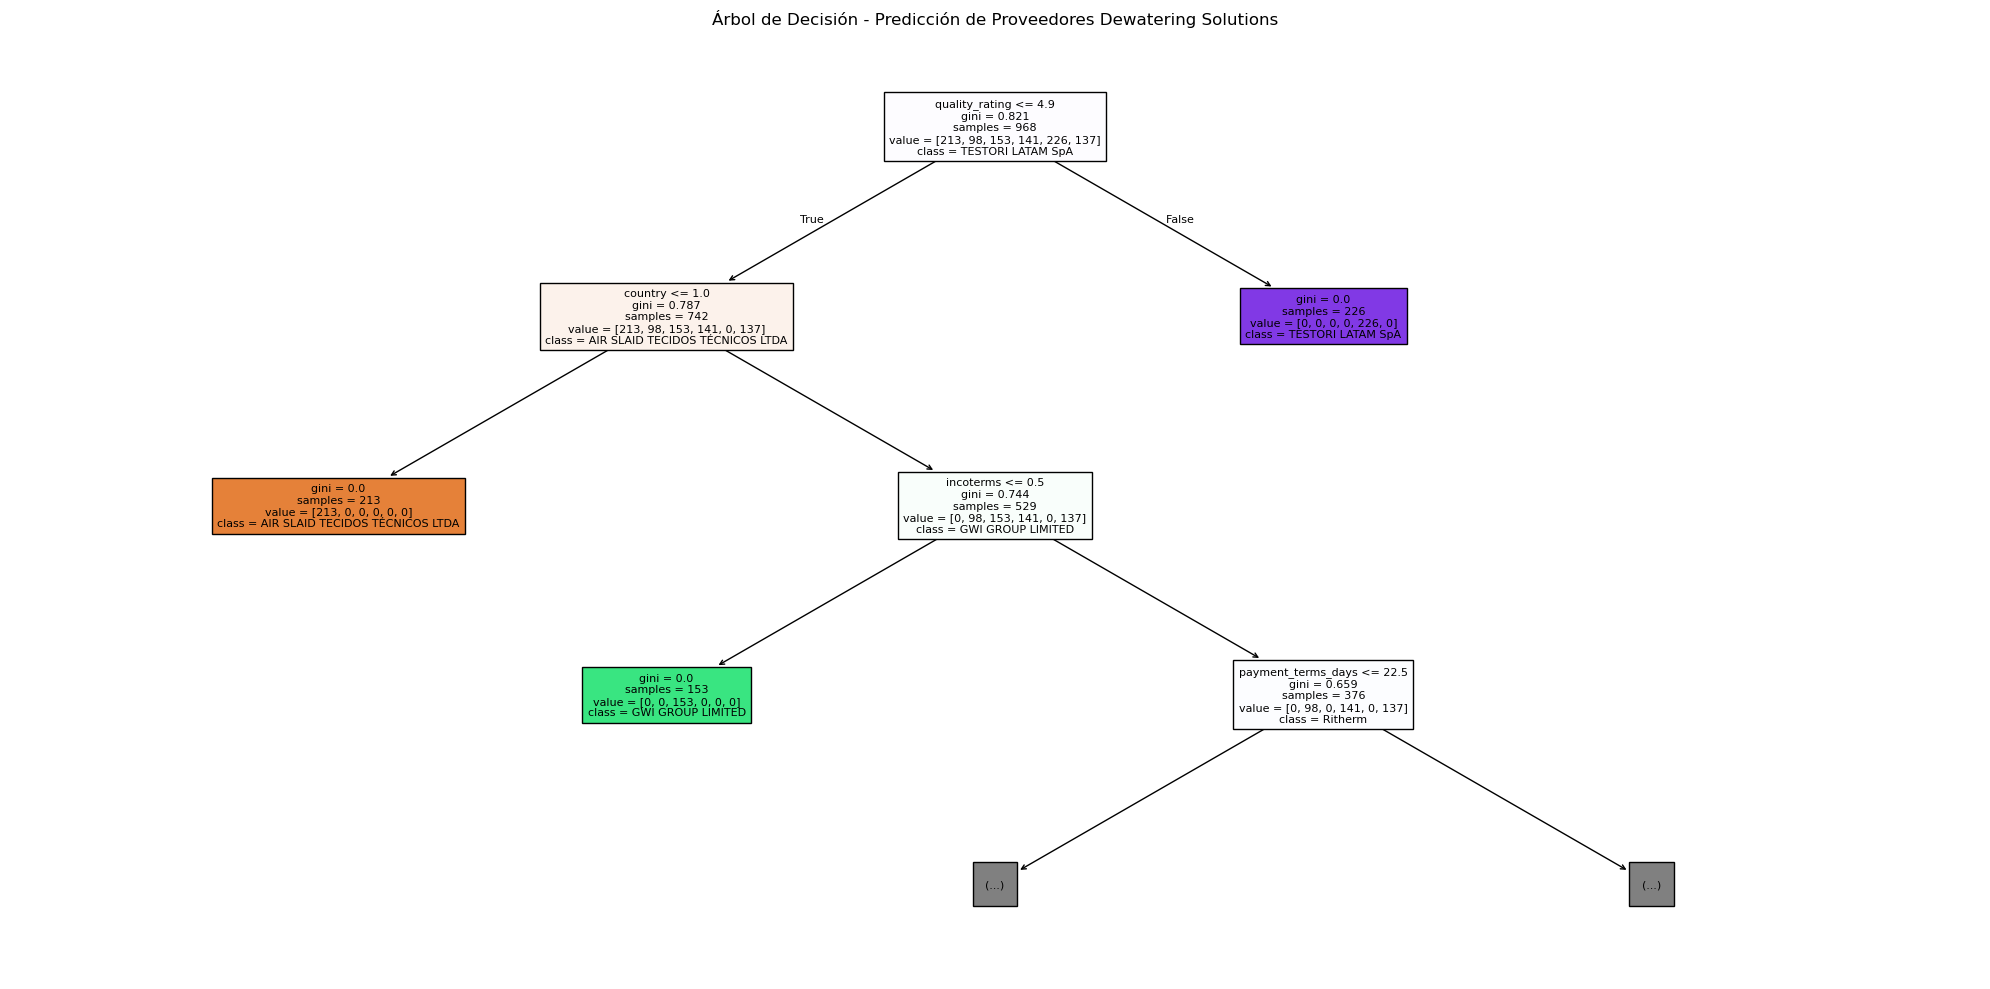


REGLAS DEL ÁRBOL (PRIMERAS 20 LÍNEAS):
|--- quality_rating <= 4.90
|   |--- country <= 1.00
|   |   |--- class: 0
|   |--- country >  1.00
|   |   |--- incoterms <= 0.50
|   |   |   |--- class: 2
|   |   |--- incoterms >  0.50
|   |   |   |--- payment_terms_days <= 22.50
|   |   |   |   |--- quality_rating <= 3.90
|   |   |   |   |   |--- class: 5
|   |   |   |   |--- quality_rating >  3.90
|   |   |   |   |   |--- class: 1
|   |   |   |--- payment_terms_days >  22.50
|   |   |   |   |--- class: 3
|--- quality_rating >  4.90
|   |--- class: 4


Modelo entrenado y guardado exitosamente!


In [8]:
print(f"\nVISUALIZACIÓN DEL ÁRBOL DE DECISIÓN")

plt.figure(figsize=(20, 10))
plot_tree(
    best_model, 
    feature_names=X.columns,
    class_names=target_encoder.classes_,
    filled=True,
    fontsize=8,
    max_depth=3  # Limitar profundidad para legibilidad
)
plt.title('Árbol de Decisión - Predicción de Proveedores Dewatering Solutions')
plt.tight_layout()
plt.show()

# Reglas del árbol en texto
print(f"\nREGLAS DEL ÁRBOL (PRIMERAS 20 LÍNEAS):")
tree_rules = export_text(best_model, feature_names=list(X.columns))
print('\n'.join(tree_rules.split('\n')[:20]))

print(f"\nModelo entrenado y guardado exitosamente!")

DIAGNÓSTICO DEL ACCURACY PERFECTO
Dataset cargado: 1211 filas, 25 columnas

Features disponibles: 14/14

1. ANÁLISIS DE DISTRIBUCIÓN DE PROVEEDORES:
supplier_name
TESTORI LATAM SpA                  283
AIR SLAID TECIDOS TÉCNICOS LTDA    266
GWI GROUP LIMITED                  191
Ritherm                            177
Xiamen Borida Products Co., Ltd    171
Autonics Perú                      123
Name: count, dtype: int64
Proveedor más frecuente: 23.4%
Proveedor menos frecuente: 10.2%
Ratio max/min: 2.3x

2. ANÁLISIS DE VARIABILIDAD EN FEATURES:
quality_rating:
  Valores únicos: 6/1211 (0.005)
  Min: 3.0, Max: 5.0
  ⚠️  BAJA VARIABILIDAD - Solo 6 valores únicos
price_usd:
  Valores únicos: 1131/1211 (0.934)
  Min: 12.76, Max: 3647.61
delivery_days:
  Valores únicos: 6/1211 (0.005)
  Min: 5, Max: 30
  ⚠️  BAJA VARIABILIDAD - Solo 6 valores únicos
payment_terms_days:
  Valores únicos: 3/1211 (0.002)
  Min: 0, Max: 30
  ⚠️  BAJA VARIABILIDAD - Solo 3 valores únicos

3. CORRELACIÓN DE FEATURE

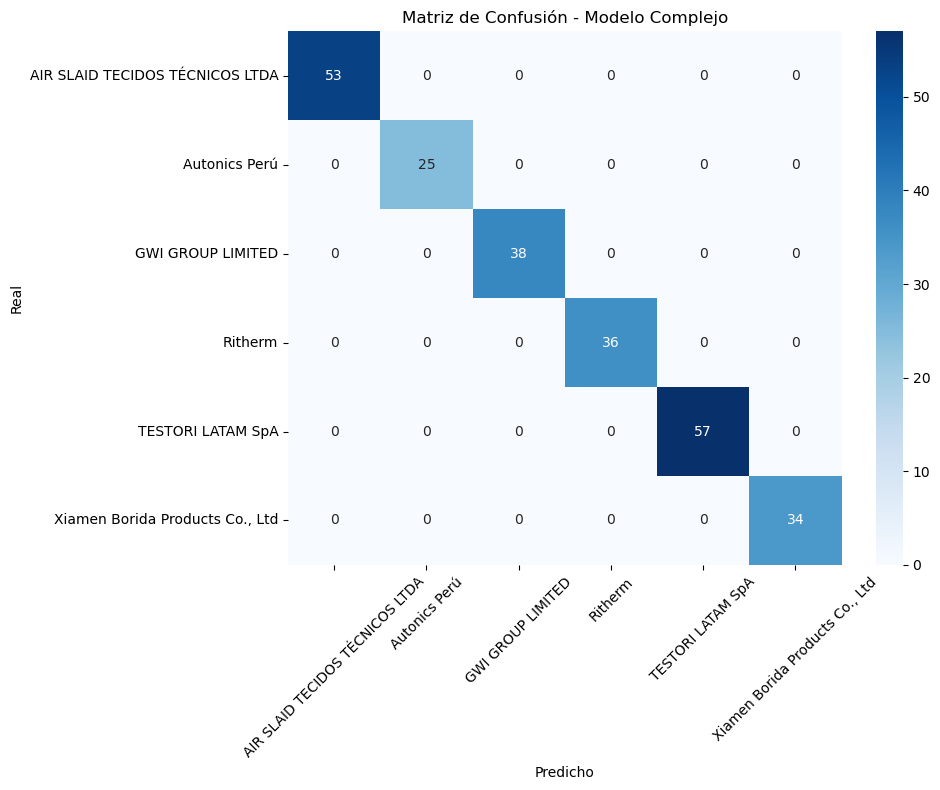


8. IMPORTANCIA DE FEATURES:
               feature  importance
0       quality_rating    0.408296
10             country    0.240130
11           incoterms    0.183633
3   payment_terms_days    0.167941
1            price_usd    0.000000
2        delivery_days    0.000000
4    shipping_included    0.000000
5    express_available    0.000000
Top 3 features explican: 83.2% de la importancia
⚠️  ALERTA: El modelo depende mucho de pocas features

9. ANÁLISIS POR PROVEEDOR:
AIR SLAID TECIDOS TÉCNICOS LTDA: 53/53 (100.0%)
Autonics Perú: 25/25 (100.0%)
GWI GROUP LIMITED: 38/38 (100.0%)
Ritherm: 36/36 (100.0%)
TESTORI LATAM SpA: 57/57 (100.0%)
Xiamen Borida Products Co., Ltd: 34/34 (100.0%)

DIAGNÓSTICO Y RECOMENDACIONES:
🚨 PROBLEMA DETECTADO: Accuracy sospechosamente alto

POSIBLES CAUSAS:
1. Dataset sintético muy predecible
2. Overfitting extremo (árbol muy profundo)
3. Pocas muestras de test
4. Desbalance de clases extremo

SOLUCIONES RECOMENDADAS:
1. Usar max_depth=3 o max_depth=5
2. Aume

In [10]:
# DIAGNÓSTICO COMPLETO DEL ACCURACY PERFECTO (1.0)
# Ejecuta esto DESPUÉS de cargar el dataset pero ANTES de entrenar

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

print("DIAGNÓSTICO DEL ACCURACY PERFECTO")
print("=" * 40)

# CARGAR DATOS Y RECREAR VARIABLES
df = pd.read_csv('../data/dewatering_realistic_supplier_dataset.csv')
print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")

# Recrear el proceso de entrenamiento con diagnóstico
features_for_model = [
    'quality_rating', 'price_usd', 'delivery_days', 'payment_terms_days',
    'shipping_included', 'express_available', 'order_urgency', 'quantity_needed',
    'budget_available', 'product_type', 'country', 'incoterms', 'month', 'quarter'
]

# Verificar features disponibles
available_features = [f for f in features_for_model if f in df.columns]
print(f"\nFeatures disponibles: {len(available_features)}/{len(features_for_model)}")

X = df[available_features].copy()
y = df['supplier_name'].copy()

# ANÁLISIS PREVIO AL ENTRENAMIENTO
print(f"\n1. ANÁLISIS DE DISTRIBUCIÓN DE PROVEEDORES:")
supplier_counts = y.value_counts()
print(supplier_counts)
print(f"Proveedor más frecuente: {supplier_counts.iloc[0]/len(y)*100:.1f}%")
print(f"Proveedor menos frecuente: {supplier_counts.iloc[-1]/len(y)*100:.1f}%")

# Verificar si hay desbalance extremo
max_ratio = supplier_counts.iloc[0] / supplier_counts.iloc[-1]
print(f"Ratio max/min: {max_ratio:.1f}x")
if max_ratio > 10:
    print("⚠️  ALERTA: Desbalance extremo de clases!")

# ANÁLISIS DE FEATURES NUMÉRICAS
print(f"\n2. ANÁLISIS DE VARIABILIDAD EN FEATURES:")
numeric_features = ['quality_rating', 'price_usd', 'delivery_days', 'payment_terms_days']
for feature in numeric_features:
    if feature in X.columns:
        unique_vals = X[feature].nunique()
        total_vals = len(X[feature])
        variability = unique_vals / total_vals
        print(f"{feature}:")
        print(f"  Valores únicos: {unique_vals}/{total_vals} ({variability:.3f})")
        print(f"  Min: {X[feature].min()}, Max: {X[feature].max()}")
        
        if variability < 0.1:
            print(f"  ⚠️  BAJA VARIABILIDAD - Solo {unique_vals} valores únicos")

# ANÁLISIS DE CORRELACIÓN CON OBJETIVO
print(f"\n3. CORRELACIÓN DE FEATURES CON PROVEEDORES:")

# Crear encoder temporal para análisis
temp_encoder = LabelEncoder()
y_encoded_temp = temp_encoder.fit_transform(y)

correlations = []
for feature in ['quality_rating', 'price_usd', 'delivery_days']:
    if feature in X.columns:
        corr = np.corrcoef(X[feature], y_encoded_temp)[0,1]
        correlations.append((feature, abs(corr)))
        print(f"{feature}: correlación = {corr:.3f}")

# Ordenar por correlación absoluta
correlations.sort(key=lambda x: x[1], reverse=True)
if correlations and correlations[0][1] > 0.8:
    print(f"⚠️  ALERTA: {correlations[0][0]} tiene correlación muy alta!")

# ENCODING Y DIVISIÓN
print(f"\n4. PREPARANDO DATOS PARA DIAGNÓSTICO:")

# Encoding de categóricas
label_encoders = {}
categorical_features = ['order_urgency', 'product_type', 'country', 'incoterms', 'quarter']

for feature in categorical_features:
    if feature in X.columns:
        le = LabelEncoder()
        X[feature] = le.fit_transform(X[feature].astype(str))
        label_encoders[feature] = le

# Convertir booleanos
boolean_features = ['shipping_included', 'express_available']
for feature in boolean_features:
    if feature in X.columns:
        X[feature] = X[feature].astype(int)

# Encoder para target
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print(f"Proveedores: {target_encoder.classes_}")

# DIVISIÓN CON MÚLTIPLES SEEDS PARA DIAGNÓSTICO
print(f"\n5. PRUEBAS CON DIFERENTES DIVISIONES:")

accuracies = []
for seed in [42, 99, 123, 456, 789]:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=seed, stratify=y_encoded
    )
    
    # Modelo simple para diagnóstico
    model = DecisionTreeClassifier(max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Seed {seed}: Accuracy = {acc:.3f}")

print(f"Accuracy promedio: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}")

if np.mean(accuracies) > 0.95:
    print("⚠️  ALERTA: Accuracy consistentemente muy alto - Posible overfitting")

# ENTRENAMIENTO CON PARÁMETROS ORIGINALES PARA ANÁLISIS DETALLADO
print(f"\n6. ANÁLISIS DETALLADO CON DIVISIÓN ESTÁNDAR:")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Recrear el modelo que dio accuracy = 1.0
complex_model = DecisionTreeClassifier(
    criterion='gini', max_depth=10, min_samples_leaf=1, 
    min_samples_split=10, random_state=42
)
complex_model.fit(X_train, y_train)
y_pred = complex_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy del modelo complejo: {accuracy:.3f}")
print(f"Profundidad del árbol: {complex_model.get_depth()}")
print(f"Número de hojas: {complex_model.get_n_leaves()}")

# MATRIZ DE CONFUSIÓN
print(f"\n7. MATRIZ DE CONFUSIÓN:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', 
           xticklabels=target_encoder.classes_,
           yticklabels=target_encoder.classes_,
           cmap='Blues')
plt.title('Matriz de Confusión - Modelo Complejo')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# IMPORTANCIA DE FEATURES
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': complex_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n8. IMPORTANCIA DE FEATURES:")
print(feature_importance.head(8))

# Verificar concentración en pocas features
top_3_importance = feature_importance.head(3)['importance'].sum()
print(f"Top 3 features explican: {top_3_importance:.1%} de la importancia")

if top_3_importance > 0.8:
    print("⚠️  ALERTA: El modelo depende mucho de pocas features")

# ANÁLISIS POR PROVEEDOR
print(f"\n9. ANÁLISIS POR PROVEEDOR:")
for supplier_idx, supplier_name in enumerate(target_encoder.classes_):
    supplier_mask = y_test == supplier_idx
    if supplier_mask.sum() > 0:
        correct = (y_pred[supplier_mask] == y_test[supplier_mask]).sum()
        total = supplier_mask.sum()
        accuracy_supplier = correct/total
        print(f"{supplier_name}: {correct}/{total} ({accuracy_supplier:.1%})")

# RECOMENDACIONES
print(f"\n" + "="*50)
print("DIAGNÓSTICO Y RECOMENDACIONES:")
print("="*50)

if accuracy >= 0.99:
    print("🚨 PROBLEMA DETECTADO: Accuracy sospechosamente alto")
    print("\nPOSIBLES CAUSAS:")
    print("1. Dataset sintético muy predecible")
    print("2. Overfitting extremo (árbol muy profundo)")
    print("3. Pocas muestras de test")
    print("4. Desbalance de clases extremo")
    
    print("\nSOLUCIONES RECOMENDADAS:")
    print("1. Usar max_depth=3 o max_depth=5")
    print("2. Aumentar min_samples_split=50")
    print("3. Aumentar min_samples_leaf=20")
    print("4. Usar validación cruzada temporal")
    print("5. Generar más variabilidad en el dataset")
    
elif accuracy >= 0.85:
    print("⚠️  Accuracy alto pero aceptable")
    print("Monitorear overfitting en datos nuevos")
    
else:
    print("✅ Accuracy en rango normal para clasificación multiclase")

print(f"\nPara continuar:")
print("1. Implementa las restricciones sugeridas")
print("2. Re-entrena con parámetros más conservadores")
print("3. Valida con datos completamente nuevos")